In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('HR_interpolated_data.csv')
data.head(10)

,PatientID,Timestamp,Metric,Value
0,132540,0.00,HR,88.0
1,132540,0.01,HR,88.0
2,132540,0.02,HR,88.0
3,132540,0.03,HR,88.0
4,132540,0.04,HR,88.0
5,132540,0.05,HR,88.0
6,132540,0.06,HR,88.0
7,132540,0.07,HR,88.0
8,132540,0.08,HR,88.0
9,132540,0.09,HR,88.0


In [4]:
data.Timestamp = data.Timestamp * 100

In [5]:
data = data.set_index('Timestamp', drop=True)

In [6]:
data.head(10)

,PatientID,Metric,Value
Timestamp,,,
0.0,132540,HR,88.0
1.0,132540,HR,88.0
2.0,132540,HR,88.0
3.0,132540,HR,88.0
4.0,132540,HR,88.0
5.0,132540,HR,88.0
6.0,132540,HR,88.0
7.0,132540,HR,88.0
8.0,132540,HR,88.0


In [177]:
data.PatientID.unique()[10:]

array([132601, 132605, 132618, ..., 142653, 142654, 142665])

In [222]:
p_ids = [138022, 141560, 142580]
current_patient = 132618

In [223]:
patient_data = data[data.PatientID == current_patient]

In [224]:
patient_data_series =  patient_data.Value.reset_index(drop=True)

In [225]:
len(patient_data_series)

3901

In [226]:
test_data_series = patient_data_series[-1100:-1000]

In [227]:
patient_data_series = patient_data_series[:-1100]

In [228]:
len(patient_data_series), len(test_data_series)

(2801, 100)

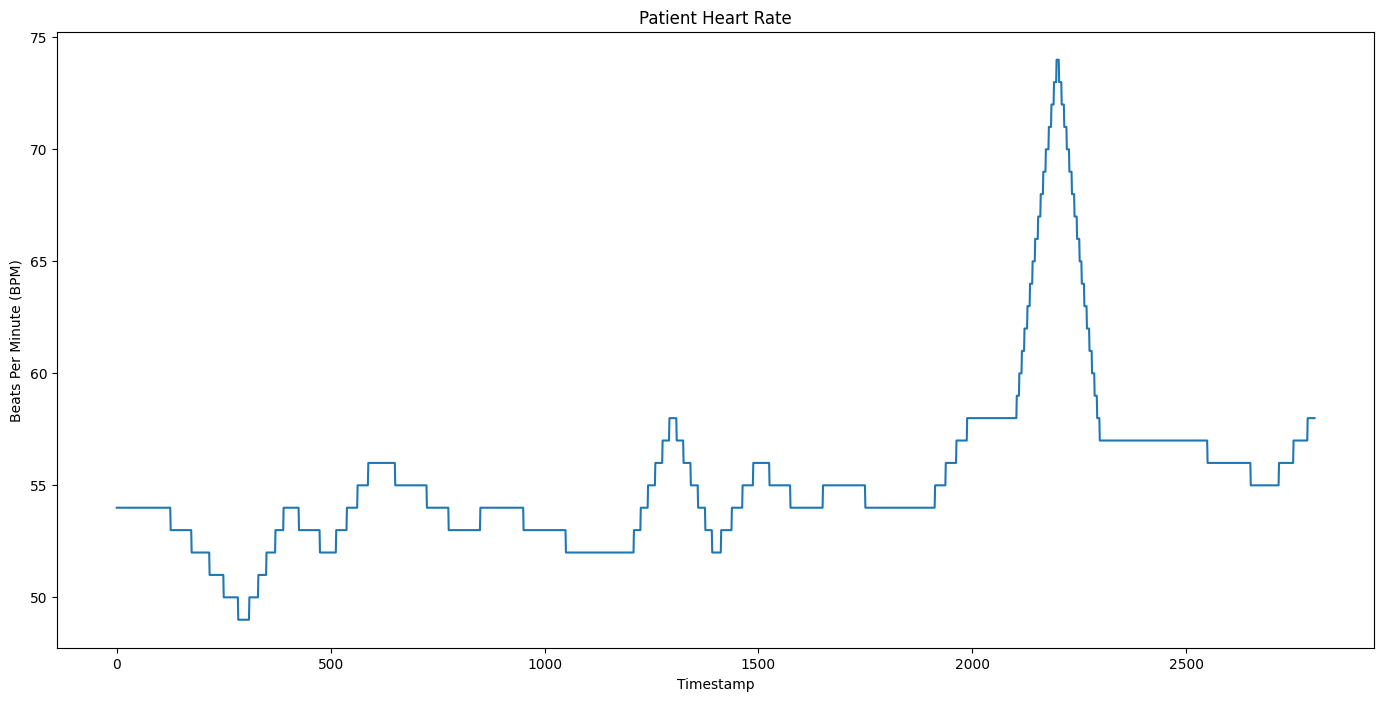

In [229]:
plt.figure(figsize=(17, 8))
plt.plot(patient_data_series)
plt.title('Patient Heart Rate')
plt.ylabel('Beats Per Minute (BPM)')
plt.xlabel('Timestamp')
plt.grid(False)
plt.show()

In [230]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

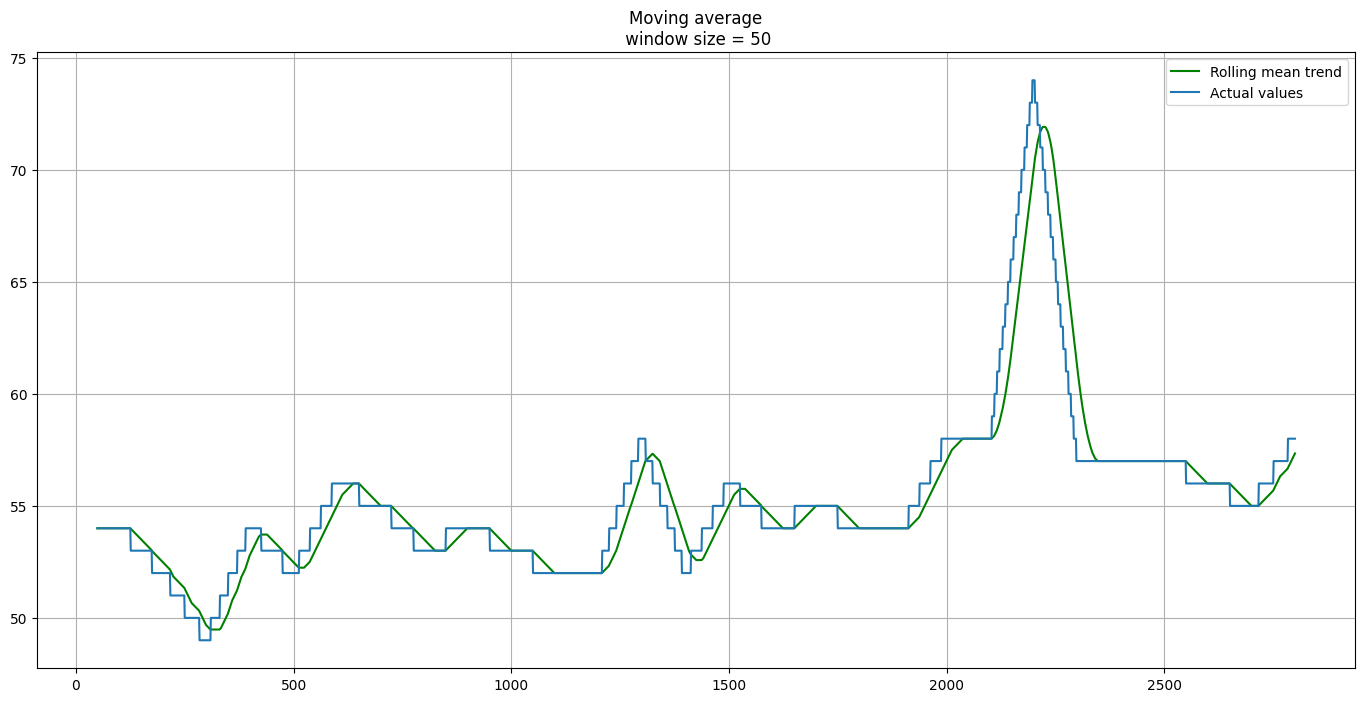

In [231]:
#Smooth by the previous 5 minutes
plot_moving_average(patient_data_series, 50)

In [232]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [233]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

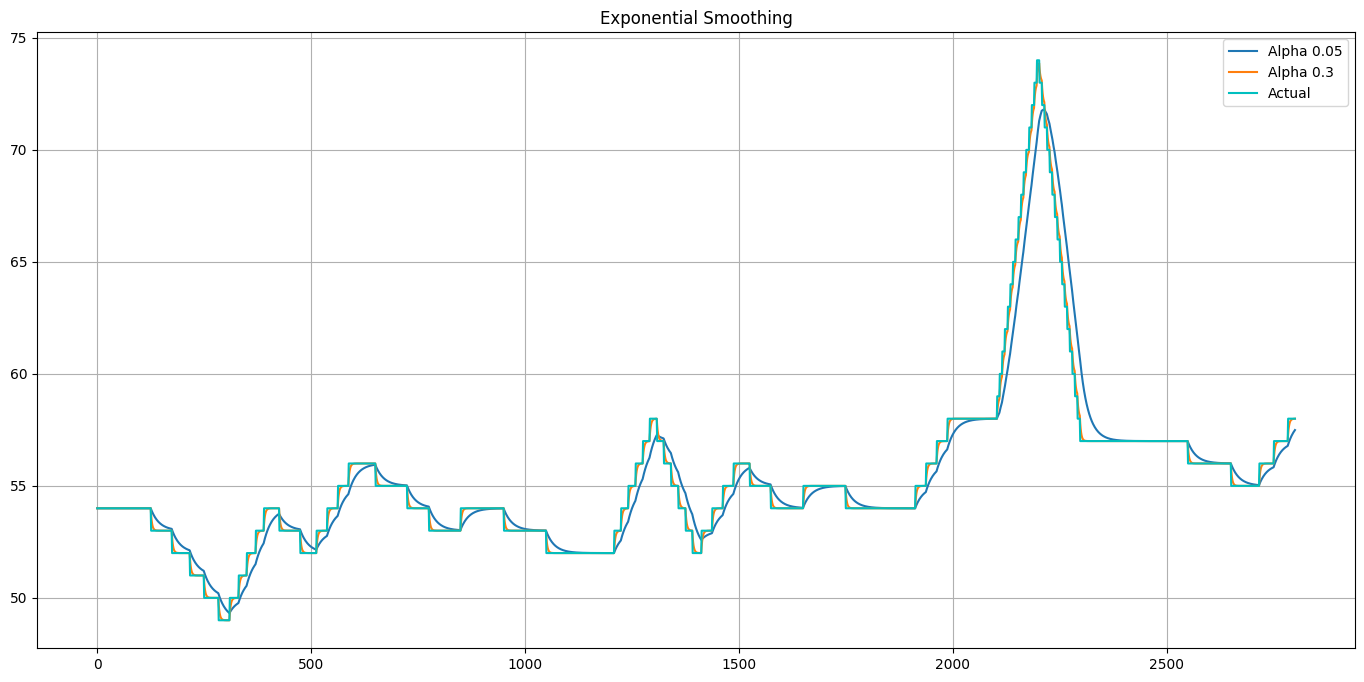

In [234]:
plot_exponential_smoothing(patient_data_series, [0.05, 0.3])

In [235]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [236]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

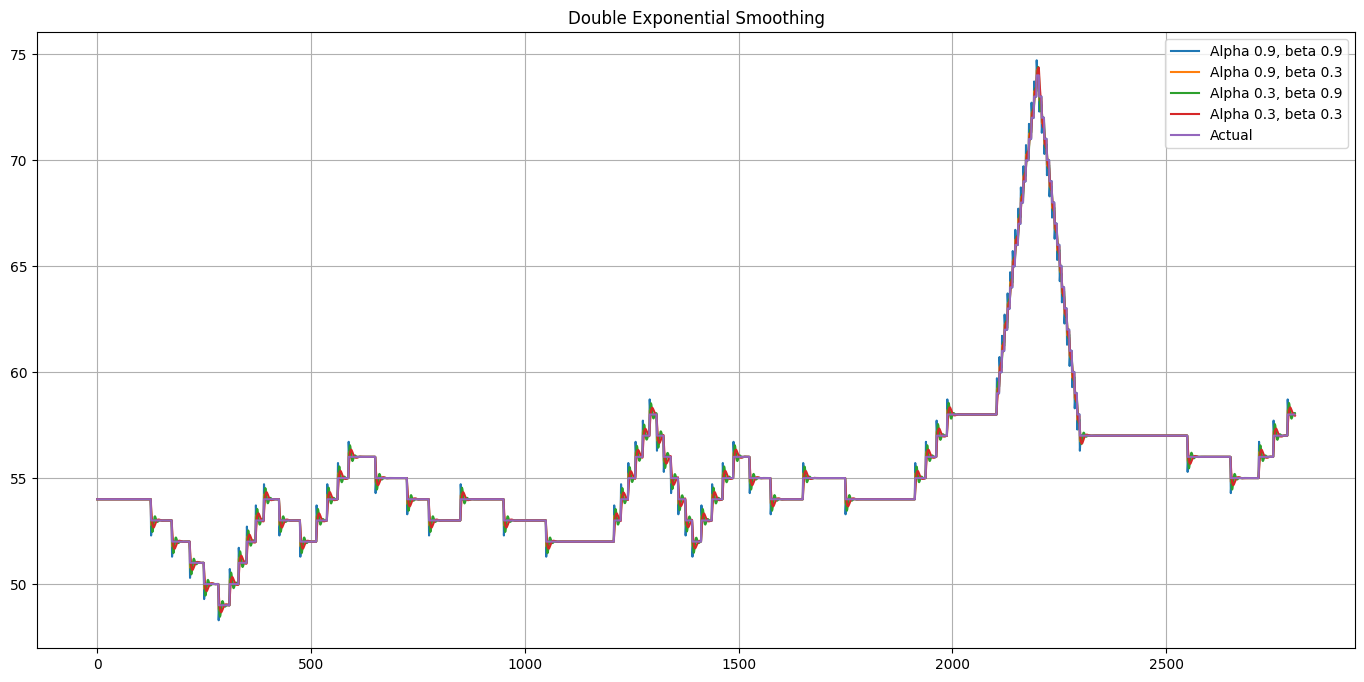

In [237]:
plot_double_exponential_smoothing(patient_data_series, alphas=[0.9, 0.3], betas=[0.9, 0.3])

In [238]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

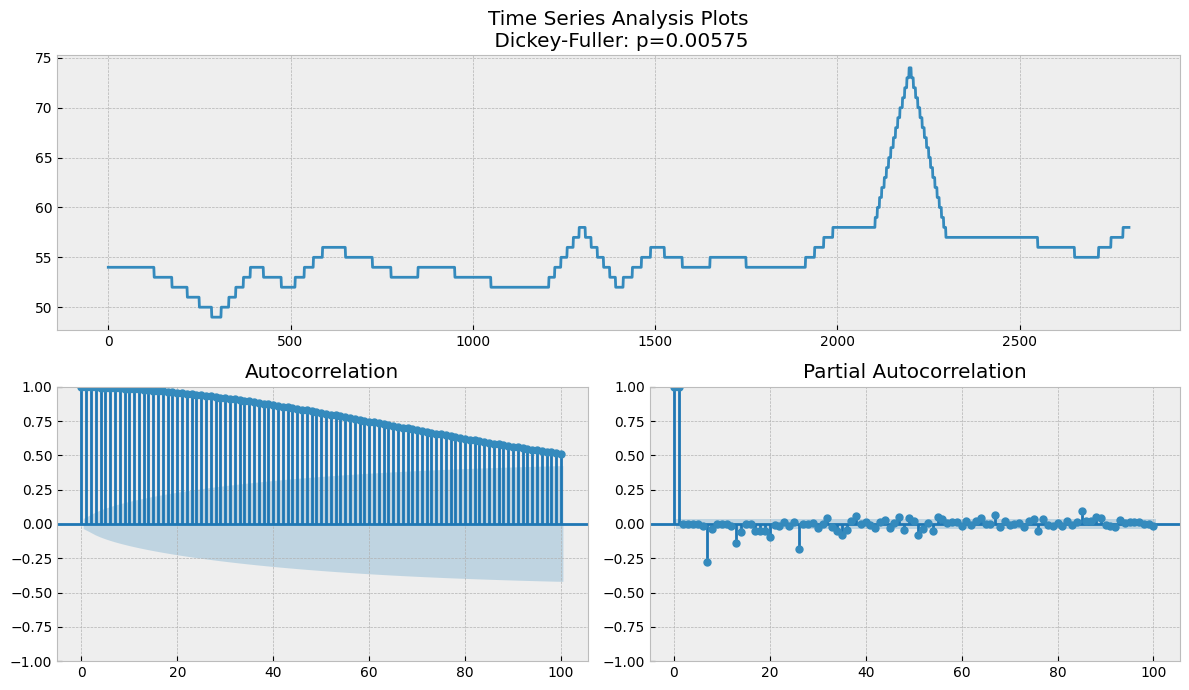

In [239]:
tsplot(patient_data_series, lags=100)

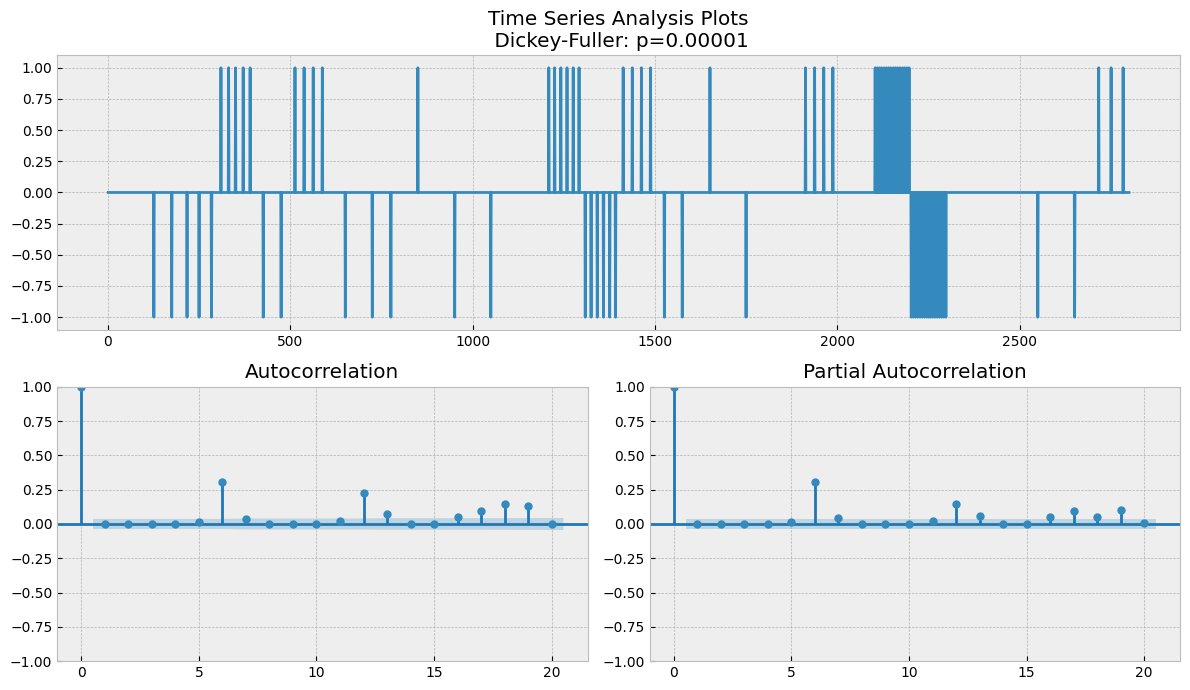

In [240]:
# Take the first difference to remove to make the process stationary
data_diff = patient_data_series - patient_data_series.shift(1)

tsplot(data_diff[1:], lags=20)

# ARIMA

In [241]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

In [242]:
# #Dataframe
# patient_data = data[data.PatientID == 138022]
# patient_data_series =  patient_data.Value.reset_index(drop=True)

# #Set initial values and some bounds
# ps = range(0, 5)
# d = 1
# qs = range(0, 5)
# Ps = range(0, 5)
# D = 1
# Qs = range(0, 5)
# s = 5

# #Create a list with all possible combinations of parameters
# parameters = product(ps, qs, Ps, Qs)
# parameters_list = list(parameters)
# len(parameters_list)

# #Create an ARIMA model with the above defined parameters and difference (lag) of 1
# model = sm.tsa.statespace.SARIMAX(patient_data_series, 
#                                   order=(0, d, 0),
#                                   seasonal_order=(2, D, 4, s)).fit(disp=-1)

# #Computing the model AIC
# model.aic

# #Forecasting with the trained model for next 100 timesteps
# forecast = model.forecast(100)

# #Combining the predictions with the original data
# final_df = pd.DataFrame({'PatientID': 142580, 'HR': pd.concat(
#   [patient_data_series, forecast])})
# final_df = final_df.reset_index()
# final_df = final_df.rename(columns = {'index': 'Timestamp'})

# #Calculating Mean Absolute Error
# error = mean_absolute_error(test_data_series, forecast)
# print(f'MAE = {error}')


In [243]:
#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [244]:
model = sm.tsa.statespace.SARIMAX(patient_data_series, order=(1, 1, 10)).fit(disp=-1)

In [245]:
model.aic

-2146.601201091086

In [246]:
forecast = model.forecast(100)

In [247]:
pd.DataFrame({"Predicted": forecast, "True": test_data_series})

,Predicted,True
2801,58.029604,58.0
2802,58.067477,58.0
2803,58.090373,58.0
2804,58.108569,58.0
2805,58.126700,58.0
...,...,...
2896,58.864347,59.0
2897,58.866891,59.0
2898,58.869381,59.0
2899,58.871819,59.0


In [248]:
final_df = pd.DataFrame({'PatientID': current_patient, 'HR': pd.concat([patient_data_series, forecast])})

In [249]:
final_df = final_df.reset_index()

In [250]:
final_df = final_df.rename(columns = {'index': 'Timestamp'})

In [251]:
final_df.head(10)

,Timestamp,PatientID,HR
0,0,132618,54.0
1,1,132618,54.0
2,2,132618,54.0
3,3,132618,54.0
4,4,132618,54.0
5,5,132618,54.0
6,6,132618,54.0
7,7,132618,54.0
8,8,132618,54.0
9,9,132618,54.0


In [252]:
# final_df.to_csv('HR_142580.csv', index=False)

In [253]:
error = mean_absolute_error(test_data_series, forecast)
print(f'MAE = {error}')

MAE = 0.312546059034499


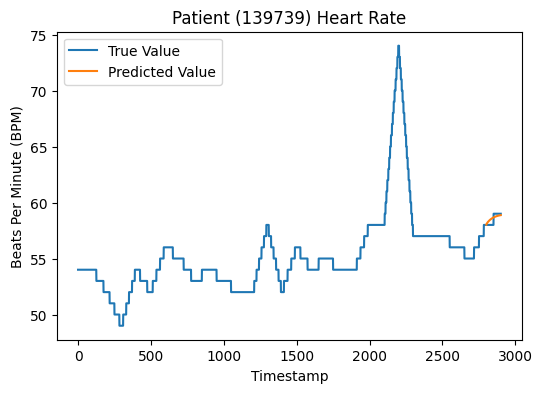

In [256]:
plt.figure(figsize=(6, 4))
plt.plot(pd.concat([patient_data_series, test_data_series]), label='True Value')
plt.plot(forecast, label='Predicted Value')
plt.title(f'Patient (139739) Heart Rate')
plt.ylabel('Beats Per Minute (BPM)')
plt.xlabel('Timestamp')
plt.grid(False)
plt.legend()
plt.show()

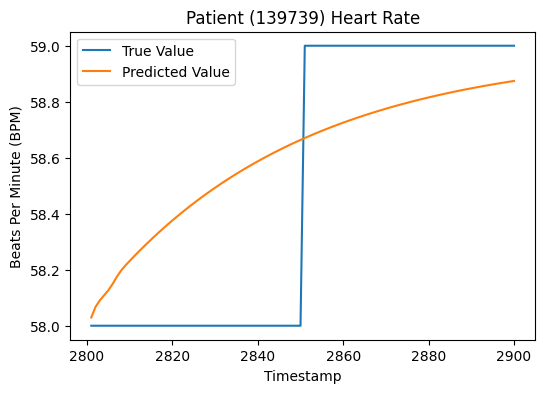

In [257]:
plt.figure(figsize=(6, 4))
plt.plot(pd.concat([patient_data_series, test_data_series])[-100:], label='True Value')
plt.plot(forecast[-100:], label='Predicted Value')
plt.title(f'Patient (139739) Heart Rate')
plt.ylabel('Beats Per Minute (BPM)')
plt.xlabel('Timestamp')
plt.grid(False)
plt.legend()
plt.show()

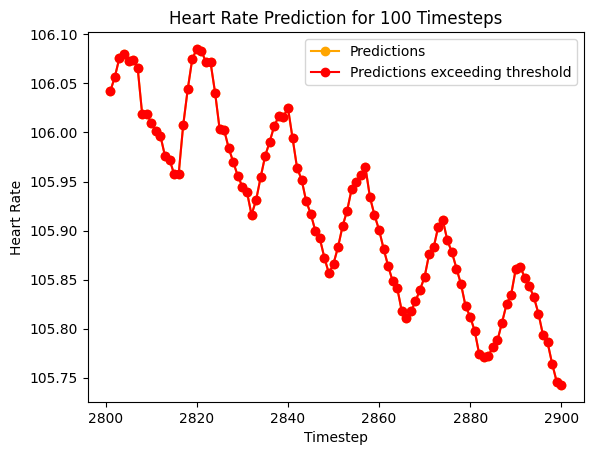

In [85]:
highlight_predictions = [pred if pred > 100 or pred < 60 else None for pred in forecast]

timesteps = np.arange(2801, 2901)

plt.plot(timesteps, forecast, label='Predictions', marker='o', linestyle='-', color='orange')
plt.plot(timesteps, highlight_predictions, label='Predictions exceeding threshold', marker='o', color='red')

plt.title('Heart Rate Prediction for 100 Timesteps')
plt.xlabel('Timestep')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()